# 04. PyTorch - Custom Datasets Notebook

We have used some datasets with PyTorch before. But, how do we get our data into PyTorch??

One of the ways to do so is via: custom datasets

## Domain libraries

We need to checkout the dataloaders and other corresponding functions and modules that correspond to the kind of the problem that we have been working on and the respective kind of data (vision, audio, recommendations etc)

## 0. Importing PyTorch and setting up the device-agnostic code

In [ ]:
import torch
from torch import nn

# Note: We need PyTorch  1.10.0+ for this course
torch.__version__

'2.4.0+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get some data

Our dataset is the subset of the Food101 Dataset in PyTorch datasets.

Food 101 has 101 different classes of food and 1000 images per each class -> 750 training images and 250 testing images

Our dataset starts with 3 classes of food and 10% of the images (~75 train, 25 test)

Why are we doing this?

When starting out ML projects, it is important to try things on small scale and then increase the scale when necessary. The whole point is to speed up how fast we can experiment. When we are testing model architectures and are experimenting with it, if we are using the entire large dataset at once, the model takes a long time to train everytime and this slows down the experimenting...

Daniel's way of creating a subset small dataset from the  existing large dataset is in the following link - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

and the created data is also stored in the github profile. We now see the way that we follow to get the data from github

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a datafolder
data_path = Path("data/") # Creates a folder "data" locally
image_path = data_path/"pizza_steak_sushi"

# If the image folder does not exist already, we download
if image_path.is_dir():
  print(f"{image_path} directory already exisits .. skipping download")
else:
  print(f"{image_path} doesn't exist...Creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data...")
  f.write(request.content)

# Unzip pizzas, steak and sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza, steak and sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist...Creating one...
Unzipping pizza, steak and sushi data


## 2. Becoming one with the data (datapreparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents. """
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [ ]:
# Setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

We are following this specific way of storing images of our datasets here to use the other dataloader functions in PyTorch. They normally have a typical setting where there are two folders "train" and "test" and each folder has severla folders with each folder having the images of one corresponding class

### 2.1 Visualizing a random image

Let us write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working  with images, let us open the image with Python's PIL -> Python imaging library
5. We'll then show the image and print metadata

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
# copy path of the said folder
# /content/data/pizza_steak_sushi

data/pizza_steak_sushi/test/pizza/1152100.jpg
pizza
Random image path: data/pizza_steak_sushi/test/pizza/1152100.jpg
Image class: pizza
Image height: 384
Image width: 512


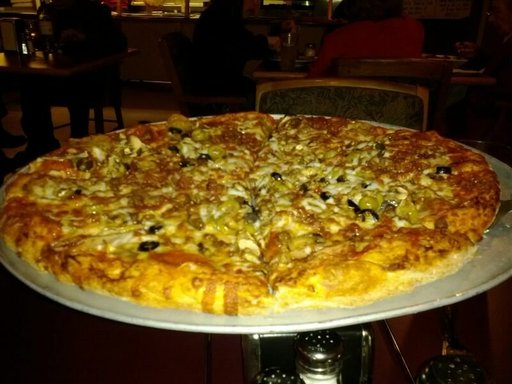

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # any image in any folder in folders consequently

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)


# Get the image class from the path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)
# For the random image data/pizza_steak_sushi/test/pizza/2019408.jpg -
# data/pizza_steak_sushi/test/pizza/ -> parent
#pizza -> stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") # Attributes of the PIL
print(f"Image width: {img.width}")

img



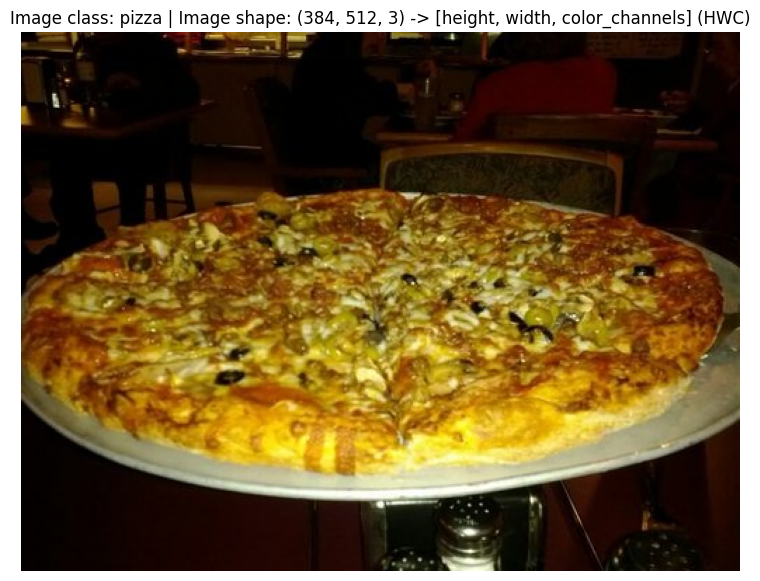

In [ ]:
# Visualizing with matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

We currently have H,W,C format for the images.

But, note that we need C,H,W format for PyTorch.

array([[[ 0,  1,  0],
        [ 0,  2,  1],
        [ 0,  4,  0],
        ...,
        [21,  6,  3],
        [19,  5,  4],
        [19,  5,  4]],

       [[ 0,  0,  2],
        [ 0,  1,  0],
        [ 0,  2,  1],
        ...,
        [21,  6,  3],
        [20,  4,  4],
        [18,  4,  3]],

       [[ 2,  1,  6],
        [ 2,  2,  4],
        [ 2,  2,  4],
        ...,
        [20,  5,  0],
        [19,  4,  1],
        [19,  4,  1]],

       ...,

       [[ 5,  1,  0],
        [ 5,  1,  0],
        [ 5,  1,  0],
        ...,
        [22,  4,  0],
        [20,  5,  0],
        [20,  5,  0]],

       [[ 5,  1,  0],
        [ 5,  1,  0],
        [ 5,  1,  0],
        ...,
        [20,  5,  0],
        [20,  5,  0],
        [20,  5,  0]],

       [[ 5,  1,  0],
        [ 5,  1,  0],
        [ 5,  1,  0],
        ...,
        [20,  5,  0],
        [20,  5,  0],
        [20,  5,  0]]], dtype=uint8)
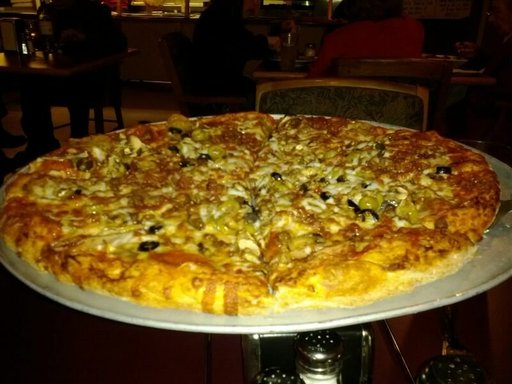

In [ ]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

 We'll call these `Dataset` and `Dataloader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with torchvision.transforms

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
     # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal (Data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    # probability -> 50 percent of the times, the images go through this transforms pipeline, it horizontally flips the image
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # Converts HWC in 0-255 to CHW in 0-1
])


In [ ]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

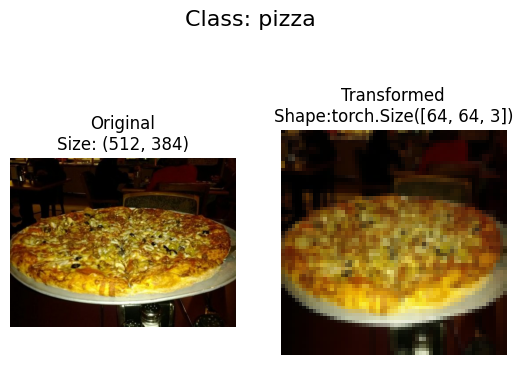

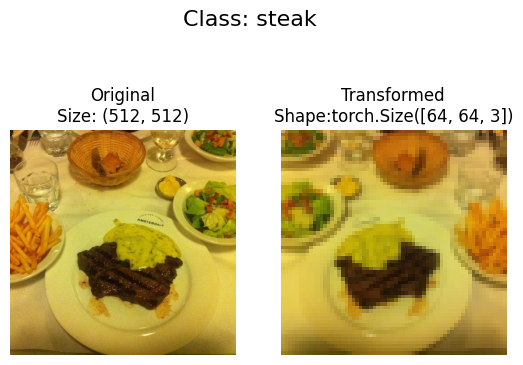

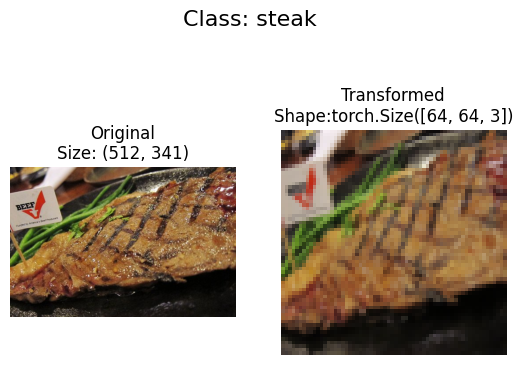

In [ ]:
def plot_transformed_images(image_paths:list,transform, n=3, seed=42):
  """
  Selects random images from a path of iamges and loads/transforms them
  then plots the original Vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # Note, we will need to change the shape again for the matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape:{transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16) # Super title

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3, # 3 images
                        seed=42)

## 4. Option1: Loading image data using ImageFolder


We can load image classification data usinf `torchvision.datasets.ImageFolder`

In [ ]:
# Using Imagefolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

It is important to note that to work with this "ImageFolder", it is important for us to have the folder tree similar to this one. We have a train folder and inside the train folder we have different folders that have the images of each individual class. The labels of the respective images are automatically inferred from the name of the folder (i.e., stem of the parent path to the current directory)

If we have a different setting of folder tree, then we need to use a different custom dataset creator to our problem

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict # String class names mapped to integers

{'pizza': 0, 'steak': 1, 'sushi': 2}

For things like this, we could have also used target_transform in Imagefolder. We can use these to create and then transform labels like we want them to.

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
train_data.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [ ]:
# Index on the train_data Dataset to get a single image and a label
img, label = train_data[0]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"Respective class of the label: {class_names[label]}")

Image tensor: 
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

Original shape: torch.Size([3, 64, 64]) -> [color channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color channels] 


Text(0.5, 1.0, 'pizza')

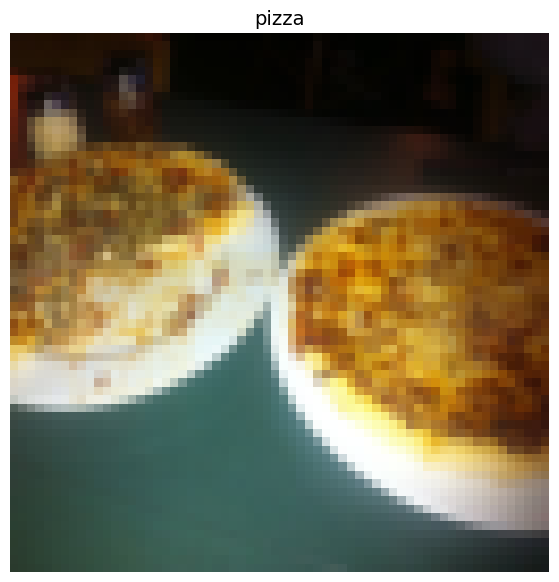

In [ ]:
# Rearrange the dimensions to make the color channels in the end (to visualize)
img_permute = img.permute(1,2,0)

# Printout the different shapes
print(f"Original shape: {img.shape} -> [color channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color channels] ")


# Plot the image
plt.figure(figsize=(10,7)),
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

## Dataloaders

Creating a train dataloader and test loader from our training data and testing data


In [ ]:
from torch.utils.data import DataLoader

# Setup the batchsize hyperparameter
BATCH_SIZE = 1

# Turn the datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers = 1, # how many cpu calls are used to load our data #
                              shuffle=True)
# more num_workers -> better, we can also set the num_workers as os.cpu_count() to use max no of cpus we have
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

# train_dataset is shuffled to ensure randomness in the data while training
# test dataset does not need shuffling as it is just testing
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ea13d297bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ea13d295f60>)

In [ ]:
len(train_dataloader), len(test_dataloader) # number of batches created from training and testing datasets

(225, 75)

In [ ]:
len(next(iter(train_dataloader))) # The iterator points towards two elements

2

In [ ]:
next(iter(train_dataloader))[0].shape #First element is X tensor [batchsize, color_channels,X]

torch.Size([1, 3, 64, 64])

In [ ]:
next(iter(train_dataloader))[1].shape # Second element is a tensor of all the labels of the entire batch of training images

torch.Size([1])

In [ ]:
# Let's check out what have we created

print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train_dataloader: {(len(train_dataloader))} batches of {BATCH_SIZE}...")
print(f"Length of the test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ea13d297bb0>, <torch.utils.data.dataloader.DataLoader object at 0x7ea13d295f60>)
Length of the train_dataloader: 225 batches of 1...
Length of the test_dataloader: 75 batches of 1...


In [ ]:
img,label = next(iter(train_dataloader))

# Batchsize will now be 1, and we can change the batchsize if we'd like
print(f"Image shape:{img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape:{label.shape}")

Image shape:torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape:torch.Size([1])


## 5 Option2: ImageFolder - From Scratch?

Loading image data with a custom 'Dataset'

1. We have used Daniel's function to get a subset of data from an exisiting big dataset Food101.

2. Now, we have the dataset in a way that there are train and test folders and inside each folder, there exists folders with all the respective class names with images corresponding to the respective class name inside the folder.

3. But, we need the training and test dataset as some tensors and labels format to further process in PyTorch dataloaders.

4. Hence, we have used ImageFolder library from PyTorch to get all the images in the corresponding subfolders in the respective folder tree as described above. This results in the traditional training and testing datasets format that we normally use.

5. We create dataloaders using the training and testing data.

But, How can we code ImageFolder from scratch to achieve the same objective?

1) Want to be able to load images from file

2) Want to be able to get class names from the Dataset

3) Want to be able to get classes as dictionaries from the Dataset


Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it'll work

* More writing code ourselves, prone to errors or performance issues

**All custom datasets in PyTorch, often subclass torch.utils.data.Dataset**

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

So, in essence, if I give a file path to a helper function, it has to go inside the folders present inside and according to the names of the subsequent folders, it should decide class names as a list and also a dictionary with the indices

### 5.1 Creating a helper function to get class names

We want the function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format(standard folder tree))

2. Raise an error if the class names are not to be found (if this happens, there might be something wrong with the directory structure)

3. Turn the class names into a dict and a list and return them

In [ ]:
# Setup path for target directory
target_directory = train_dir # directory from which we should load the data from
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [ ]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted([entry.name for entry in list(os.scandir(directory)) if entry.is_dir()])

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check the file structure")

  # 3, Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i,class_name in enumerate(classes)}
  return classes, class_to_idx

[(0, 'pizza'), (1, 'steak'), (2, 'sushi')]

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})